In [1]:
import numpy as np
from numba import *
from astropy import units
from itertools import product
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize

In [2]:
vcm = 184
vsigma = 16.8

spawn molecules in a circle of 2 cm diameter at 1/4" distance from the cell

In [3]:
@njit
def generate_random_coords_circle(coords, R):
    size = coords.shape[-1]
    idx = 0
    while idx < size:
        c = (np.random.random(2)-0.5)*2 * R
        if np.sqrt(np.sum(c**2)) <= R:
            coords[:,idx] = c
            idx += 1
            
generate_random_longitudinal_velocities = lambda x: np.random.normal(vcm, vsigma, x)
generate_random_transverse_velocities = lambda x: np.random.normal(0, vsigma, x)

def generate_random_transverse_velocities(size):
    theta = np.random.random(size)*2*np.pi
    v = np.random.normal(0, vsigma, size)
    v_transverse = np.empty([2,size])
    v_transverse[0,:] = np.cos(theta)*v
    v_transverse[1,:] = np.sin(theta)*v
    return v_transverse

In [4]:
R = 0.01
size = int(1e6)
coords = np.empty([2,size])
generate_random_coords_circle(coords, R)
v_z = generate_random_longitudinal_velocities(size)
v_x, v_y = generate_random_transverse_velocities(size)

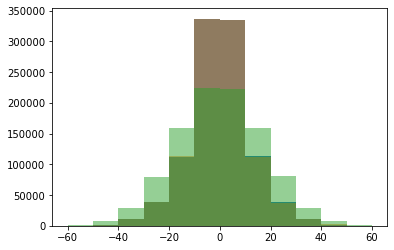

In [5]:
b = np.linspace(-60,60,13)
plt.hist(v_x, bins = b)
plt.hist(v_y, alpha = 0.5, bins = b)
plt.hist(np.random.normal(0, vsigma, size), bins = b, alpha = 0.5);

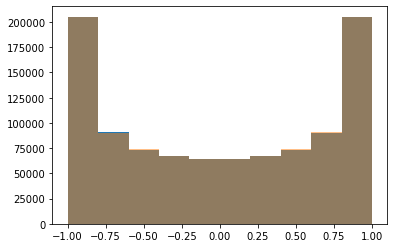

In [6]:
theta = np.random.random(size)*2*np.pi
plt.hist(np.cos(theta))
plt.hist(np.sin(theta), alpha = 0.5);

distance to RC laser from cell opening is 21.75"  
distance to aperture #1 from cell opening is 17.36"  

distance to LIF laser from cell opening is 38.39"  
distance to aperture #2 from cel opening is 35.37" 

In [7]:
in_to_m = (units.imperial.inch).to(units.m)

In [8]:
distance_aperture_1 = 17.36 * in_to_m - 0.25 * in_to_m

coords_aperture_1 = np.empty([3,size])

dt = distance_aperture_1/v_z
coords_aperture_1[0,:] = coords[0,:]+dt*v_x
coords_aperture_1[1,:] = coords[1,:]+dt*v_y
coords_aperture_1[2,:] = distance_aperture_1

In [9]:
distance_aperture_2 = 35.37 * in_to_m - 0.25 * in_to_m

coords_aperture_2 = np.empty([3,size])

dt = distance_aperture_2/v_z
coords_aperture_2[0,:] = coords[0,:]+dt*v_x
coords_aperture_2[1,:] = coords[1,:]+dt*v_y
coords_aperture_2[2,:] = distance_aperture_2

In [10]:
distance_laser_rc = 21.75 * in_to_m - 0.25 * in_to_m
dt = distance_laser_rc/v_z
interaction_rc = np.sum(np.abs(coords[1,:]+dt*v_y) < 0.005)

In [11]:
distance_laser_lif = 38.30 * in_to_m - 0.25 * in_to_m
dt = distance_laser_lif/v_z
interaction_lif = np.sum(np.abs(coords[1,:]+dt*v_y) < 0.005)

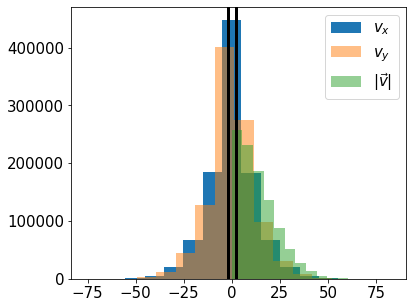

In [12]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

v_acceptable = 2

ax.hist(v_x, bins = bins, label = r'$v_x$')
ax.hist(v_y, bins = bins, alpha = 0.5, label = r'$v_y$')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = bins, alpha = 0.5, label = r'$|\vec{v}|$')

ax.legend(fontsize = 15)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 15)

aperture #1 radius 1.0 mm
accepted 1.1% of trajectories
aperture #1 radius 2.0 mm
accepted 4.5% of trajectories
aperture #1 radius 3.0 mm
accepted 10.0% of trajectories
aperture #1 radius 4.0 mm
accepted 17.7% of trajectories
aperture #1 radius 5.0 mm
accepted 27.2% of trajectories
aperture #1 radius 6.0 mm
accepted 38.6% of trajectories
aperture #1 radius 7.0 mm
accepted 51.6% of trajectories
aperture #1 radius 8.0 mm
accepted 65.7% of trajectories
aperture #1 radius 9.0 mm
accepted 80.5% of trajectories


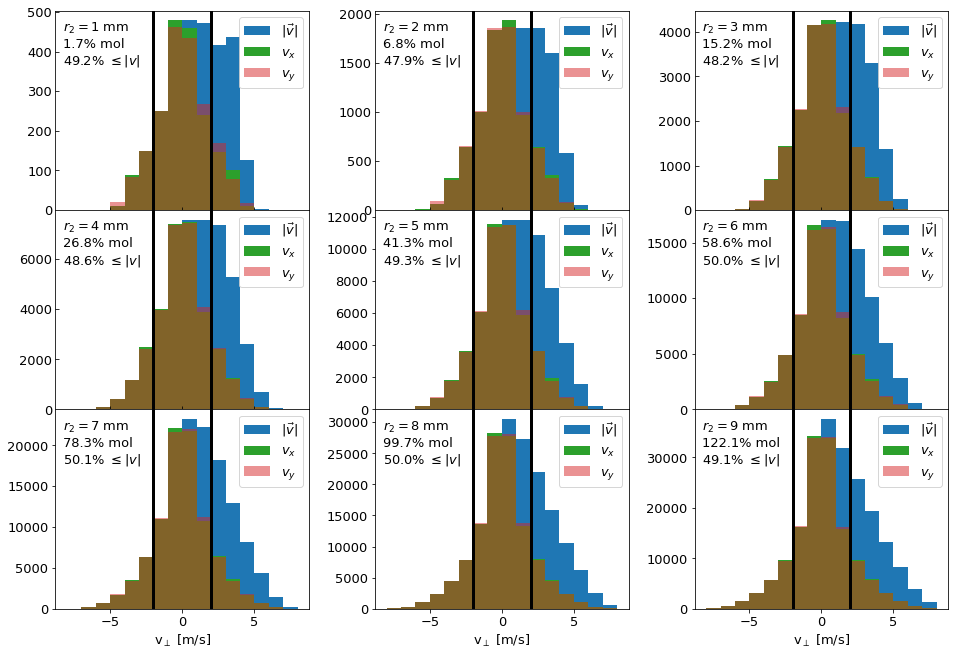

In [13]:
aperture_1_radii = np.linspace(0.001,0.009,9)

percentage_within_limits_1 = {r:0 for r in aperture_1_radii}

bins = np.arange(-8,8+1)

v_acceptable = 2

fig, ax = plt.subplots(3,3,figsize = (16,11), sharex = True,
                      gridspec_kw={'hspace': 0, 'wspace': .26, 'height_ratios': [1,1,1]})

axp = {r:ax.flatten()[idx] for idx,r in enumerate(aperture_1_radii)}
for r in aperture_1_radii:
    m = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r
    
    axp[r].hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
    axp[r].hist(v_x[m], bins = bins, label = r'$v_x$', color = 'C2')
    axp[r].hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$', color = 'C3')
    
    axp[r].legend(fontsize = 13, loc = 1)
    
    axp[r].axvline(v_acceptable, lw = 3, color = 'k')
    axp[r].axvline(-v_acceptable, lw = 3, color = 'k')

    axp[r].set_xlabel(r'v$_\perp$ [m/s]')

    set_fontsize(axp[r], 13)
    
    """
    Calculating the # of trajectories accepted by the aperture, where 
    I divide by the total # that the laser can interact with.
    Here total # the laser can interact with is simply calculated from 
    the size of the laser beam, no transverse velocity is taken into account.
    (Which will decrease the #, and increase the percentage)
    """
    print('='*30)
    print(f'aperture #1 radius {r*1e3:.1f} mm')
    print(f'accepted {m.sum()/interaction_rc*100:.1f}% of trajectories')
    
    """
    Calculating the percentage of velocities within the acceptable range
    that make it through the aperture.
    """
    v_abs = np.sqrt(v_x[m]**2+v_y[m]**2)
    percentage_within_limits_1[r] = (100*(v_abs < v_acceptable).sum()/m.sum())
    
    text = f'$r_2 = ${r*1e3:.0f} mm'+'\n'
    text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
    text += f'{(100*(v_abs < v_acceptable).sum()/m.sum()):.1f}% $\leq |v|$'
    axp[r].text(0.03, 0.95, text, transform = axp[r].transAxes,
                ha = 'left', va = 'top', fontsize = 13)
    
for ax in list(axp.values())[:len(axp)//2]:
    ax.tick_params(direction = 'in')

aperture #2 radius 1.0 mm
accepted 0.8% of trajectories
aperture #2 radius 2.0 mm
accepted 3.3% of trajectories
aperture #2 radius 3.0 mm
accepted 7.5% of trajectories
aperture #2 radius 4.0 mm
accepted 13.2% of trajectories
aperture #2 radius 5.0 mm
accepted 20.5% of trajectories
aperture #2 radius 6.0 mm
accepted 29.0% of trajectories
aperture #2 radius 7.0 mm
accepted 38.5% of trajectories
aperture #2 radius 8.0 mm
accepted 49.1% of trajectories
aperture #2 radius 9.0 mm
accepted 60.2% of trajectories


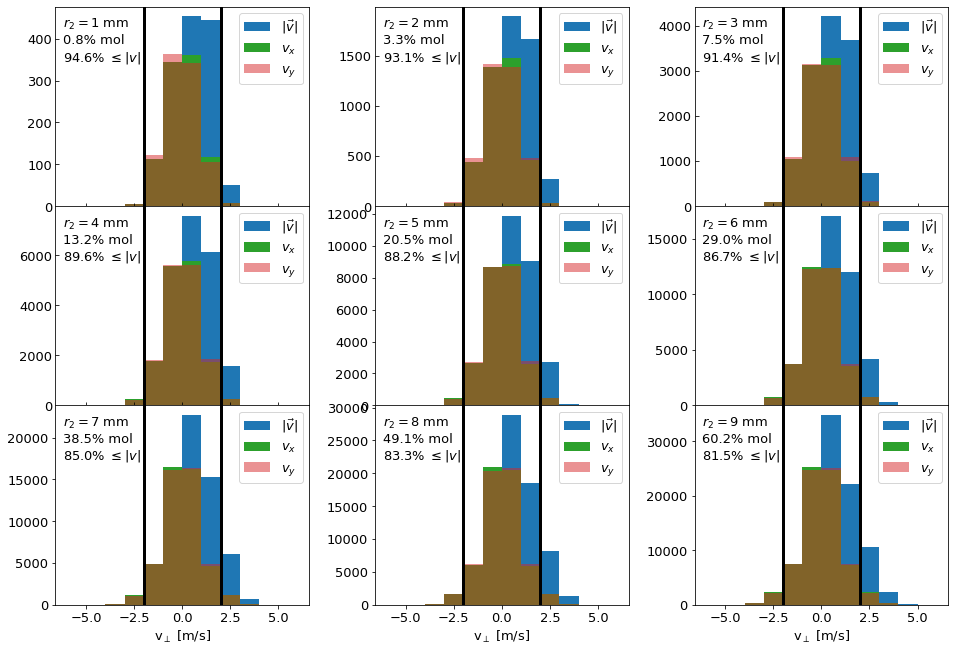

In [14]:
aperture_2_radii = np.linspace(0.001,0.009,9)

percentage_within_limits_2 = {r:0 for r in aperture_2_radii}

fig, ax = plt.subplots(3,3,figsize = (16,11), sharex = True,
                      gridspec_kw={'hspace': 0, 'wspace': .26, 'height_ratios': [1,1,1]})

bins = np.arange(-6,6+1)

v_acceptable = 2

axp = {r:ax.flatten()[idx] for idx,r in enumerate(aperture_2_radii)}
for r in aperture_2_radii:
    m = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r

    axp[r].hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
    axp[r].hist(v_x[m], bins = bins, label = r'$v_x$', color = 'C2')
    axp[r].hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$', color = 'C3')
    
    axp[r].legend(fontsize = 13, loc = 1)
    
    axp[r].axvline(v_acceptable, lw = 3, color = 'k')
    axp[r].axvline(-v_acceptable, lw = 3, color = 'k')
    
    axp[r].set_xlabel(r'v$_\perp$ [m/s]')
    
    set_fontsize(axp[r], 13)
    
    
    """
    Calculating the # of trajectories accepted by the aperture, where 
    I divide by the total # that the laser can interact with.
    Here total # the laser can interact with is simply calculated from 
    the size of the laser beam, no transverse velocity is taken into account.
    (Which will decrease the #, and increase the percentage)
    """
    print('='*30)
    print(f'aperture #2 radius {r*1e3:.1f} mm')
    print(f'accepted {m.sum()/interaction_lif*100:.1f}% of trajectories')
    
    """
    Calculating the percentage of velocities within the acceptable range
    that make it through the aperture.
    """
    v_abs = np.sqrt(v_x[m]**2+v_y[m]**2)
    percentage_within_limits_2[r] = (100*(v_abs < v_acceptable).sum()/m.sum())
    
    text = f'$r_2 = ${r*1e3:.0f} mm'+'\n'
    text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
    text += f'{(100*(v_abs < v_acceptable).sum()/m.sum()):.1f}% $\leq |v|$'
    axp[r].text(0.03, 0.95, text, transform = axp[r].transAxes,
                ha = 'left', va = 'top', fontsize = 13)
    
for ax in list(axp.values())[:len(axp)//2]:
    ax.tick_params(direction = 'in')

aperture radii : r1 = 1 mm, r2 = 4 mm
accepted 0.7% of trajectories
aperture radii : r1 = 1 mm, r2 = 5 mm
accepted 0.8% of trajectories
aperture radii : r1 = 1 mm, r2 = 6 mm
accepted 1.0% of trajectories
aperture radii : r1 = 1 mm, r2 = 7 mm
accepted 1.1% of trajectories
aperture radii : r1 = 1 mm, r2 = 8 mm
accepted 1.3% of trajectories
aperture radii : r1 = 1 mm, r2 = 9 mm
accepted 1.4% of trajectories
aperture radii : r1 = 2 mm, r2 = 4 mm
accepted 2.5% of trajectories
aperture radii : r1 = 2 mm, r2 = 5 mm
accepted 3.2% of trajectories
aperture radii : r1 = 2 mm, r2 = 6 mm
accepted 3.9% of trajectories
aperture radii : r1 = 2 mm, r2 = 7 mm
accepted 4.5% of trajectories
aperture radii : r1 = 2 mm, r2 = 8 mm
accepted 5.1% of trajectories
aperture radii : r1 = 2 mm, r2 = 9 mm
accepted 5.6% of trajectories
aperture radii : r1 = 3 mm, r2 = 4 mm
accepted 5.5% of trajectories
aperture radii : r1 = 3 mm, r2 = 5 mm
accepted 7.1% of trajectories
aperture radii : r1 = 3 mm, r2 = 6 mm
accepted 8

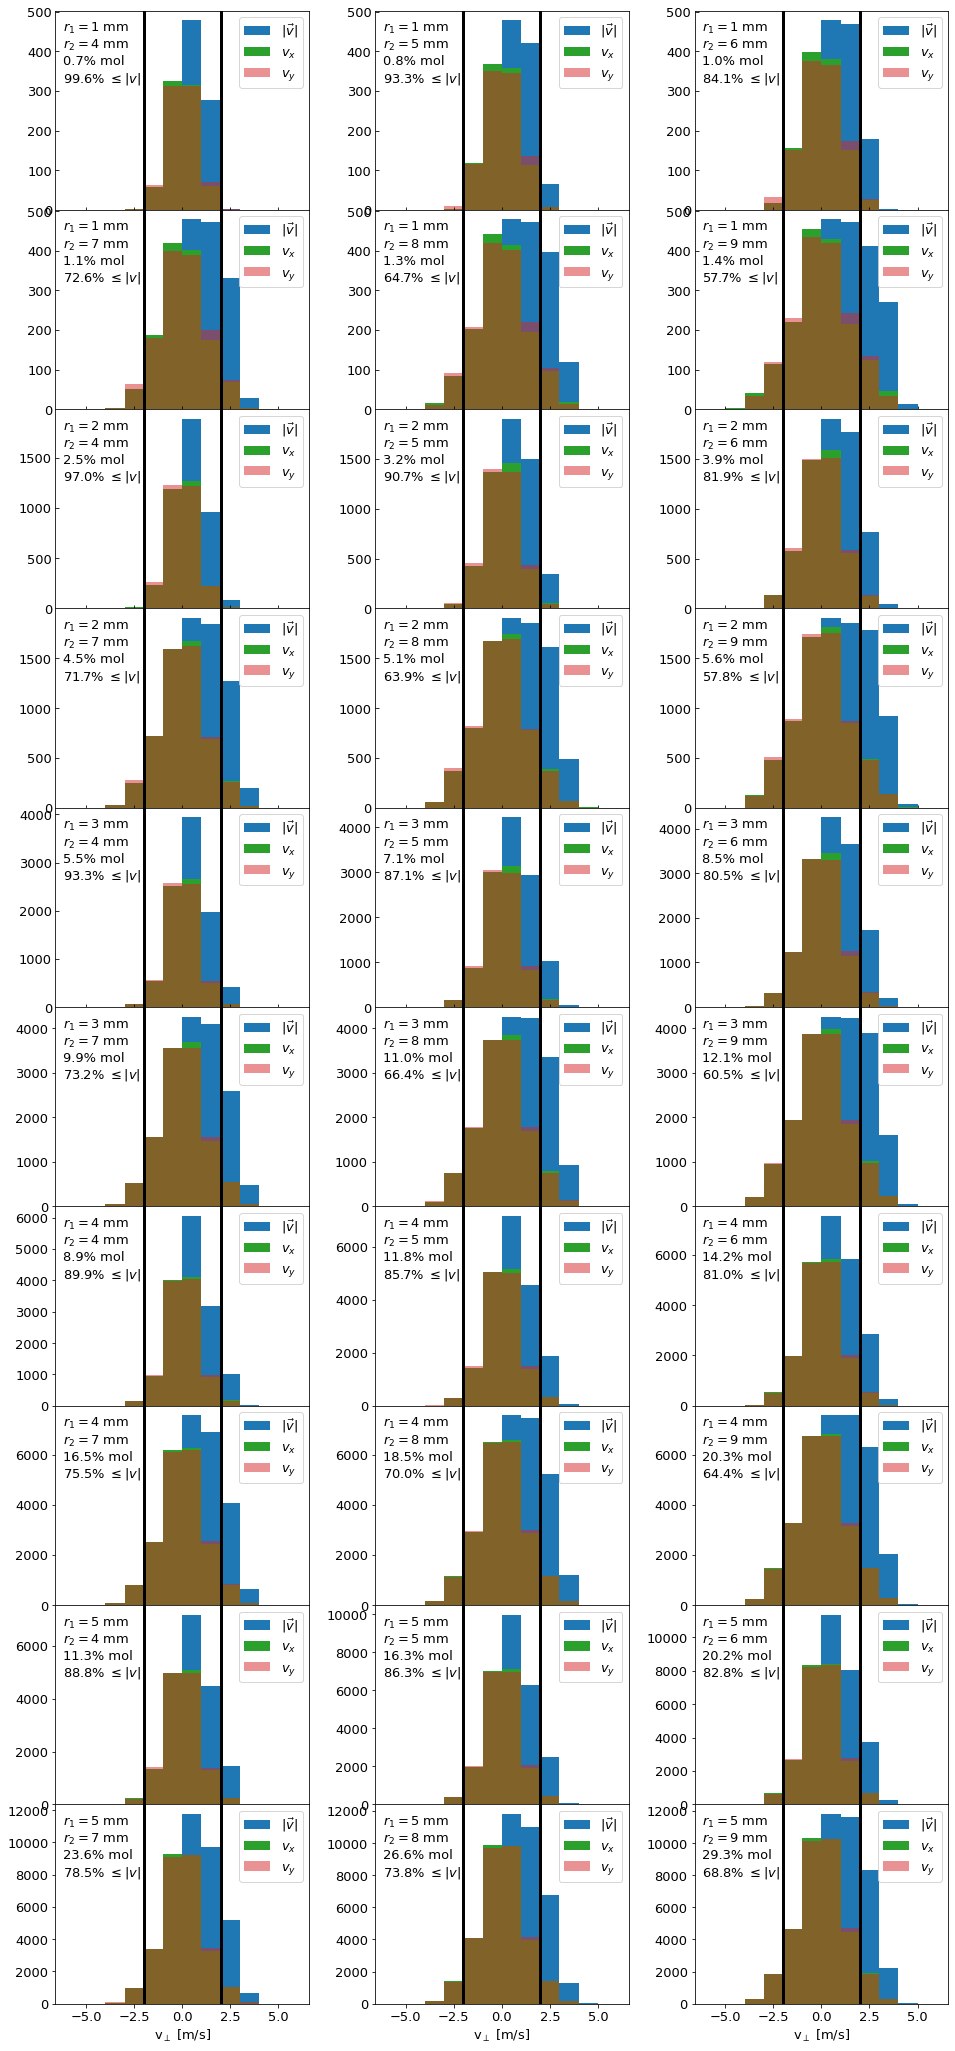

In [30]:
aperture_1_radii = np.linspace(0.001,0.005,5)
aperture_2_radii = np.linspace(0.004,0.009,6)
radii = list(product(aperture_1_radii, aperture_2_radii))

percentage_within_limits_both = {(np.round(r1,3),np.round(r2,3)):0 for r1,r2 in radii}
molecules_accepted_both = {(np.round(r1,3),np.round(r2,3)):0 for r1,r2 in radii}

fig, ax = plt.subplots(10,3,figsize = (16,11/3*10), sharex = True,
                      gridspec_kw={'hspace': 0, 'wspace': .26})

bins = np.arange(-6,6+1)

v_acceptable = 2



axp = {(np.round(r1,3),np.round(r2,3)):ax.flatten()[idx] for idx,(r1,r2) in enumerate(radii)}
for r1,r2 in radii:
    r1 = np.round(r1,3)
    r2 = np.round(r2,3)
    
    m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
    m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
    m = m1 & m2

    axp[(r1,r2)].hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, zorder = 0, label = r'$|\vec{v}|$')
    axp[(r1,r2)].hist(v_x[m], bins = bins, label = r'$v_x$', color = 'C2')
    axp[(r1,r2)].hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$', color = 'C3')
    
    axp[(r1,r2)].legend(fontsize = 13, loc = 1)
    
    axp[(r1,r2)].axvline(v_acceptable, lw = 3, color = 'k')
    axp[(r1,r2)].axvline(-v_acceptable, lw = 3, color = 'k')
    
    axp[(r1,r2)].set_xlabel(r'v$_\perp$ [m/s]')
    
    set_fontsize(axp[(r1,r2)], 13)
    
    """
    Calculating the percentage of velocities within the acceptable range
    that make it through the aperture.
    """
    v_abs = np.sqrt(v_x[m]**2+v_y[m]**2)
    percentage_within_limits_both[(r1,r2)] = (100*(v_abs < v_acceptable).sum()/m.sum())

    """
    Calculating the # of trajectories accepted by the aperture, where 
    I divide by the total # that the laser can interact with.
    Here total # the laser can interact with is simply calculated from 
    the size of the laser beam, no transverse velocity is taken into account.
    (Which will decrease the #, and increase the percentage)
    """
    print('='*40)
    print(f'aperture radii : r1 = {r1*1e3:.0f} mm, r2 = {r2*1e3:.0f} mm')
    print(f'accepted {m.sum()/interaction_lif*100:.1f}% of trajectories')
    molecules_accepted_both[(r1,r2)] = m.sum()/interaction_lif*100
    
    text = f'$r_1 = ${r1*1e3:.0f} mm'+'\n'
    text += f'$r_2 = ${r2*1e3:.0f} mm'+'\n'
    text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
    text += f'{(100*(v_abs < v_acceptable).sum()/m.sum()):.1f}% $\leq |v|$'
    axp[(r1,r2)].text(0.03, 0.95, text, transform = axp[(r1,r2)].transAxes,
                ha = 'left', va = 'top', fontsize = 13)
    
for ax in list(axp.values())[:len(axp)//2]:
    ax.tick_params(direction = 'in')

In [31]:
from tqdm import tqdm

aperture_1_radii = np.linspace(0.001,0.01,31)
aperture_2_radii = np.linspace(0.001,0.01,31)
radii = list(product(aperture_1_radii, aperture_2_radii))

percentage_within_limits_both = {(r1,r2):0 for r1,r2 in radii}
molecules_accepted_both = {(r1,r2):0 for r1,r2 in radii}

v_acceptable = 2

for r1,r2 in tqdm(radii):
    
    m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
    m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
    m = m1 & m2   
    """
    Calculating the percentage of velocities within the acceptable range
    that make it through the aperture.
    """
    v_abs = np.sqrt(v_x[m]**2+v_y[m]**2)
    percentage_within_limits_both[(r1,r2)] = (100*(v_abs < v_acceptable).sum()/m.sum())

    """
    Calculating the # of trajectories accepted by the aperture, where 
    I divide by the total # that the laser can interact with.
    Here total # the laser can interact with is simply calculated from 
    the size of the laser beam, no transverse velocity is taken into account.
    (Which will decrease the #, and increase the percentage)
    """
    molecules_accepted_both[(r1,r2)] = m.sum()/interaction_lif*100

100%|████████████████████████████████████████████████████████████████████████████████| 961/961 [00:31<00:00, 30.85it/s]


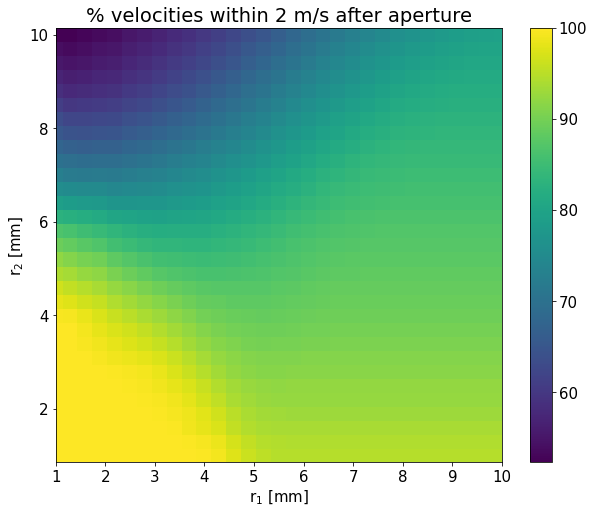

In [32]:
from scipy import interpolate

r1,r2 = zip(*list(percentage_within_limits_both.keys()))
data = np.array(list(percentage_within_limits_both.values()))

X,Y = np.meshgrid(r1, r2)
Z = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X*1e3,Y*1e3,Z, shading = 'nearest')
cbar = fig.colorbar(c, ax = ax)

ax.set_xlabel(r'r$_1$ [mm]')
ax.set_ylabel(r'r$_2$ [mm]')

ax.set_title(f'% velocities within {v_acceptable} m/s after aperture')

set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

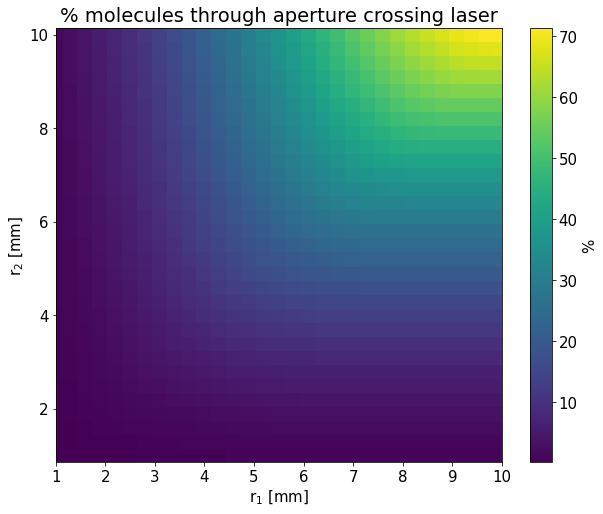

In [33]:
from scipy import interpolate

r1,r2 = zip(*list(molecules_accepted_both.keys()))
data = np.array(list(molecules_accepted_both.values()))

X,Y = np.meshgrid(r1, r2)
Z = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X*1e3,Y*1e3,Z, shading = 'nearest')
cbar = fig.colorbar(c, ax = ax)
cbar.ax.set_ylabel('%')

ax.set_xlabel(r'r$_1$ [mm]')
ax.set_ylabel(r'r$_2$ [mm]')

ax.set_title('% molecules through aperture crossing laser')

set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

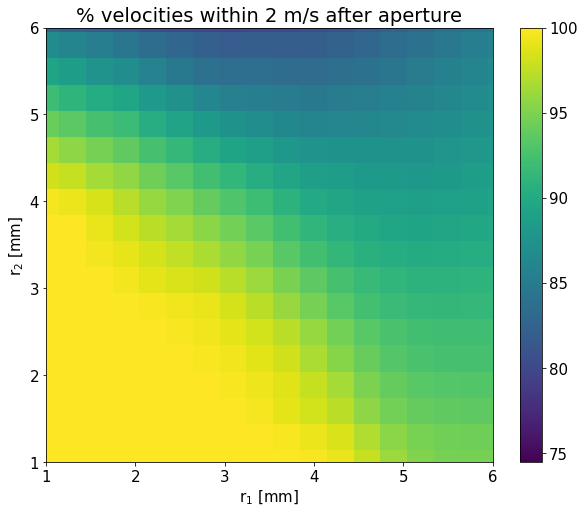

In [41]:
r1_lim = 0.007
r2_lim = 0.007
r1 = []
r2 = []
data = []
for (r_1,r_2),d in percentage_within_limits_both.items():
    if (r_1 < r1_lim) & (r_2 < r2_lim):
        r1.append(r_1)
        r2.append(r_2)
        data.append(d)

X,Y = np.meshgrid(r1, r2)
Z = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X*1e3,Y*1e3,Z, shading = 'nearest')
cbar = fig.colorbar(c, ax = ax)

ax.set_xlabel(r'r$_1$ [mm]')
ax.set_ylabel(r'r$_2$ [mm]')

ax.set_title(f'% velocities within {v_acceptable} m/s after aperture')

ax.set_xlim(1,6)
ax.set_ylim(1,6)

set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

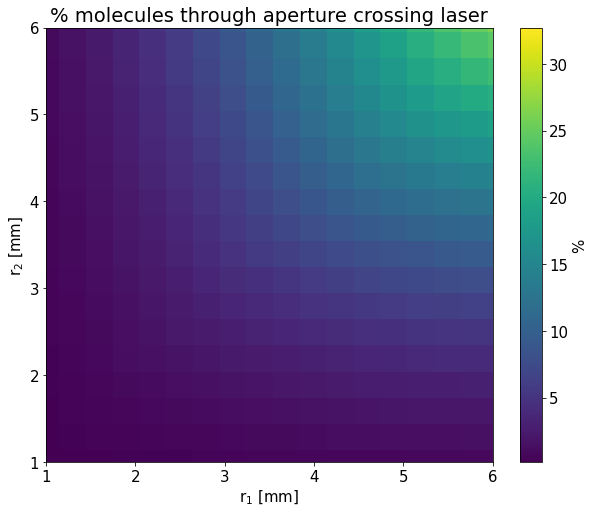

In [42]:
r1_lim = 0.007
r2_lim = 0.007
r1 = []
r2 = []
data = []
for (r_1,r_2),d in molecules_accepted_both.items():
    if (r_1 < r1_lim) & (r_2 < r2_lim):
        r1.append(r_1)
        r2.append(r_2)
        data.append(d)

X,Y = np.meshgrid(r1, r2)
Z = interpolate.griddata((r1, r2), data, (X,Y), method='nearest')

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X*1e3,Y*1e3,Z, shading = 'nearest')
cbar = fig.colorbar(c, ax = ax)
cbar.ax.set_ylabel('%')

ax.set_xlabel(r'r$_1$ [mm]')
ax.set_ylabel(r'r$_2$ [mm]')

ax.set_title('% molecules through aperture crossing laser')

ax.set_xlim(1,6)
ax.set_ylim(1,6)

set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)